In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the movie budgets data
tn_budgets = pd.read_csv(r"C:\Users\jakeg\Phase2Project\data\tn.movie_budgets.csv.gz")

# Clean monetary columns
tn_budgets['worldwide_gross'] = pd.to_numeric(tn_budgets['worldwide_gross'].str.replace('$', '').str.replace(',', ''), errors='coerce')
tn_budgets['production_budget'] = pd.to_numeric(tn_budgets['production_budget'].str.replace('$', '').str.replace(',', ''), errors='coerce')

# Identify franchises (more comprehensive list)
franchise_keywords = ['Chapter', 'Part', 'Volume', '2', '3', '4', '5', 'Saga', 'Returns', 'Revenge', 
                     'Avengers', 'Batman', 'Spider-Man', 'Star Wars', 'Fast & Furious']

tn_budgets['is_franchise'] = tn_budgets['movie'].apply(lambda x: any(keyword in x for keyword in franchise_keywords))

print("Dataset Overview:")
print(tn_budgets.info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   int64 
 6   is_franchise       5782 non-null   bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 276.8+ KB
None


Franchise vs Non-Franchise Comparison:
             production_budget       worldwide_gross   ROI
                          mean count            mean  mean
is_franchise                                              
False              30223656.25  5400    8.357037e+07  3.80
True               50870858.12   382    2.034045e+08  3.78


<Figure size 864x432 with 0 Axes>

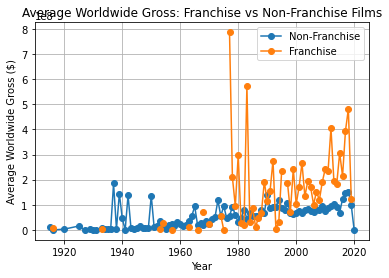

In [2]:
# Add release year and ROI calculations
tn_budgets['year'] = pd.to_datetime(tn_budgets['release_date']).dt.year
tn_budgets['ROI'] = (tn_budgets['worldwide_gross'] - tn_budgets['production_budget']) / tn_budgets['production_budget']

# Compare franchise vs non-franchise performance
comparison = tn_budgets.groupby('is_franchise').agg({
    'production_budget': ['mean', 'count'],
    'worldwide_gross': 'mean',
    'ROI': 'mean'
}).round(2)

print("Franchise vs Non-Franchise Comparison:")
print(comparison)

# Plot average worldwide gross by year for franchise vs non-franchise
plt.figure(figsize=(12, 6))
yearly_performance = tn_budgets.groupby(['year', 'is_franchise'])['worldwide_gross'].mean().unstack()
yearly_performance.plot(kind='line', marker='o')
plt.title('Average Worldwide Gross: Franchise vs Non-Franchise Films')
plt.xlabel('Year')
plt.ylabel('Average Worldwide Gross ($)')
plt.legend(['Non-Franchise', 'Franchise'])
plt.grid(True)

Most Successful Franchise Starters (2010+):
                                    movie  year  production_budget  \
5    Star Wars Ep. VII: The Force Awakens  2015          306000000   
6                  Avengers: Infinity War  2018          300000000   
33                         Jurassic World  2015          215000000   
66                              Furious 7  2015          190000000   
26                           The Avengers  2012          225000000   
3                 Avengers: Age of Ultron  2015          330600000   
41                          Black Panther  2018          200000000   
4       Star Wars Ep. VIII: The Last Jedi  2017          317000000   
112        Jurassic World: Fallen Kingdom  2018          170000000   
155                                Frozen  2013          150000000   

     worldwide_gross       ROI  
5         2053311220  5.710167  
6         2048134200  5.827114  
33        1648854864  6.669092  
66        1518722794  6.993278  
26        1517935897

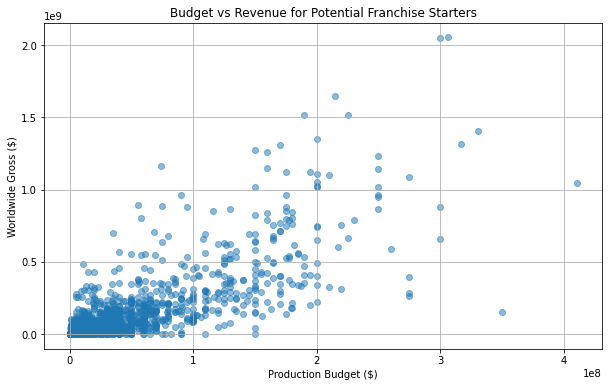

In [ ]:
# Look at first movies in franchises (removing sequels)
sequel_indicators = ['2', '3', '4', '5', 'Chapter', 'Part', 'Returns', 'Revenge']
is_sequel = tn_budgets['movie'].apply(lambda x: any(indicator in x for indicator in sequel_indicators))

franchise_starters = tn_budgets[~is_sequel & (tn_budgets['year'] >= 2010)]
print("Most Successful Franchise Starters (2010+):")
print(franchise_starters.nlargest(10, 'worldwide_gross')[['movie', 'year', 'production_budget', 'worldwide_gross', 'ROI']])

# Plot budget vs revenue relationship
plt.figure(figsize=(10, 6))
plt.scatter(franchise_starters['production_budget'], 
           franchise_starters['worldwide_gross'],
           alpha=0.5)
plt.xlabel('Production Budget ($)')
plt.ylabel('Worldwide Gross ($)')
plt.title('Budget vs Revenue for Potential Franchise Starters')
plt.grid(True)

In [4]:
# Extract primary genre from movie titles and descriptions
# Let's use TMDb data for better genre classification
tmdb_data = pd.read_csv(r"C:\Users\jakeg\Phase2Project\data\tmdb.movies.csv.gz")

# Merge with our budget data
# First, clean up titles for matching
tmdb_data['clean_title'] = tmdb_data['title'].str.lower().str.replace('[^a-zA-Z0-9 ]', '')
tn_budgets['clean_title'] = tn_budgets['movie'].str.lower().str.replace('[^a-zA-Z0-9 ]', '')

# Merge datasets
merged_data = pd.merge(tn_budgets, tmdb_data[['clean_title', 'genres']], on='clean_title', how='left')

# Calculate genre ROI
merged_data['genre_list'] = merged_data['genres'].str.split('|')
genre_df = merged_data.explode('genre_list')

genre_analysis = genre_df.groupby('genre_list').agg({
   'production_budget': 'mean',
   'worldwide_gross': 'mean',
   'ROI': ['mean', 'count']
}).round(2)

print("Genre Performance Analysis:")
print(genre_analysis.sort_values(('ROI', 'mean'), ascending=False))

KeyError: "['genres'] not in index"

In [5]:
# Look at TMDb columns
print("TMDb Data Columns:")
print(tmdb_data.columns)

# Then let's look at a few rows
print("\nSample TMDb Data:")
print(tmdb_data.head())

TMDb Data Columns:
Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count',
       'clean_title'],
      dtype='object')

Sample TMDb Data:
   Unnamed: 0            genre_ids     id original_language  \
0           0      [12, 14, 10751]  12444                en   
1           1  [14, 12, 16, 10751]  10191                en   
2           2        [12, 28, 878]  10138                en   
3           3      [16, 35, 10751]    862                en   
4           4        [28, 878, 12]  27205                en   

                                 original_title  popularity release_date  \
0  Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19   
1                      How to Train Your Dragon      28.734   2010-03-26   
2                                    Iron Man 2      28.515   2010-05-07   
3                                     Toy Story      28.005   1995-11-22   
4  

In [6]:
# Create a genre mapping dictionary (standard TMDb genre IDs)
genre_map = {
    12: 'Adventure',
    14: 'Fantasy',
    16: 'Animation',
    28: 'Action',
    35: 'Comedy',
    878: 'Science Fiction',
    10751: 'Family'
}

# Convert genre_ids from string to list and map to genre names
tmdb_data['genre_list'] = tmdb_data['genre_ids'].apply(eval).apply(lambda x: [genre_map.get(id, 'Other') for id in x])

# Merge and analyze
merged_data = pd.merge(tn_budgets, tmdb_data[['clean_title', 'genre_list']], on='clean_title', how='inner')

# Explode genre lists for analysis
genre_analysis = merged_data.explode('genre_list').groupby('genre_list').agg({
    'production_budget': ['mean', 'count'],
    'worldwide_gross': 'mean',
    'ROI': 'mean'
}).round(2)

print("Genre Performance Analysis:")
print(genre_analysis.sort_values(('worldwide_gross', 'mean'), ascending=False))

Genre Performance Analysis:
                production_budget       worldwide_gross   ROI
                             mean count            mean  mean
genre_list                                                   
Adventure            1.013137e+08   385    3.335214e+08  2.08
Animation            8.232196e+07   156    3.241137e+08  3.98
Fantasy              8.671085e+07   235    3.002140e+08  3.57
Family               7.481245e+07   241    2.738048e+08  3.93
Science Fiction      7.521505e+07   285    2.450846e+08  2.87
Action               7.523222e+07   569    2.325341e+08  1.76
Comedy               3.556395e+07   725    1.222872e+08  2.52
Other                2.713117e+07  3334    7.933765e+07  3.33


In [7]:
# Add franchise analysis to genre breakdown
merged_data['ROI'] = (merged_data['worldwide_gross'] - merged_data['production_budget']) / merged_data['production_budget']

genre_franchise = merged_data.explode('genre_list').groupby(['genre_list', 'is_franchise']).agg({
    'production_budget': ['mean', 'count'],
    'worldwide_gross': 'mean',
    'ROI': 'mean'
}).round(2)

print("Genre Performance - Franchise vs Non-Franchise:")
print(genre_franchise.sort_values(('worldwide_gross', 'mean'), ascending=False))

Genre Performance - Franchise vs Non-Franchise:
                             production_budget       worldwide_gross   ROI
                                          mean count            mean  mean
genre_list      is_franchise                                              
Adventure       True              1.411605e+08    38    6.172818e+08  3.40
Science Fiction True              1.436708e+08    24    5.886290e+08  2.97
Animation       True              1.091190e+08    21    5.454053e+08  4.20
Fantasy         True              1.271765e+08    17    5.030089e+08  3.18
Family          True              1.038846e+08    26    4.668481e+08  3.55
Action          True              1.146333e+08    57    4.621839e+08  2.84
Adventure       False             9.695010e+07   347    3.024467e+08  1.93
Comedy          True              7.046271e+07    59    2.949607e+08  3.03
Animation       False             7.815352e+07   135    2.896905e+08  3.94
Fantasy         False             8.355528e+07   218

Top Animation/Family Franchise Starters:
                    movie  production_budget  worldwide_gross        ROI
35          Black Panther          200000000       1348258224   5.741291
144                Frozen          150000000       1272469910   7.483133
120  Beauty and the Beast          160000000       1259199706   6.869998
122  Beauty and the Beast          160000000       1259199706   6.869998
37          Incredibles 2          200000000       1242520711   5.212604
430               Minions           74000000       1160336173  14.680219
41            Toy Story 3          200000000       1068879522   4.344398
415       Despicable Me 3           75000000       1034727750  12.796370
44    Alice in Wonderland          200000000       1025491110   4.127456
40           Finding Dory          200000000       1021215193   4.106076


<ipython-input-8-fdfa8e12249a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animation_family['budget_range'] = pd.qcut(animation_family['production_budget'], 4)


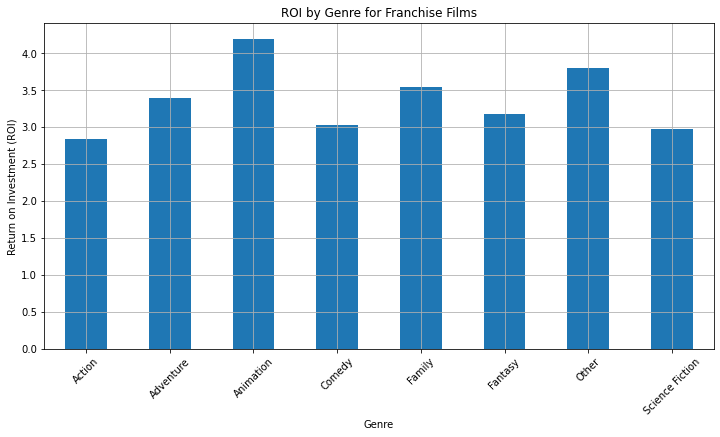

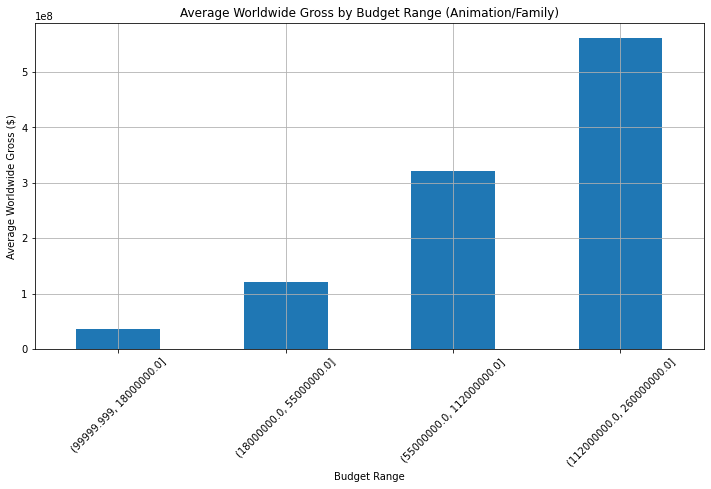

In [8]:
# First, let's look at top Animation/Family franchise starters
animation_family = merged_data[
    merged_data['genre_list'].apply(lambda x: 'Animation' in x or 'Family' in x)
]
print("Top Animation/Family Franchise Starters:")
print(animation_family.nlargest(10, 'worldwide_gross')[['movie', 'production_budget', 'worldwide_gross', 'ROI']])

# Visualization 1: ROI by Genre for Franchises
plt.figure(figsize=(12, 6))
franchise_roi = genre_franchise.xs(True, level='is_franchise')['ROI']['mean']
franchise_roi.plot(kind='bar')
plt.title('ROI by Genre for Franchise Films')
plt.xlabel('Genre')
plt.ylabel('Return on Investment (ROI)')
plt.xticks(rotation=45)
plt.grid(True)

# Visualization 2: Average Gross by Budget Range for Franchises
plt.figure(figsize=(12, 6))
animation_family['budget_range'] = pd.qcut(animation_family['production_budget'], 4)
budget_performance = animation_family.groupby('budget_range')['worldwide_gross'].mean()
budget_performance.plot(kind='bar')
plt.title('Average Worldwide Gross by Budget Range (Animation/Family)')
plt.xlabel('Budget Range')
plt.ylabel('Average Worldwide Gross ($)')
plt.xticks(rotation=45)
plt.grid(True)

<Figure size 864x432 with 0 Axes>

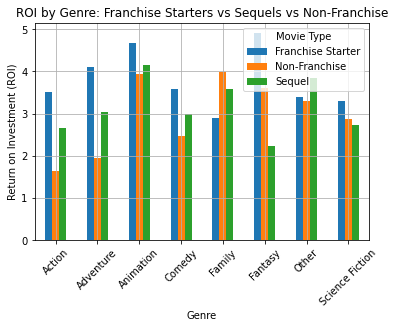

In [9]:
# Identify franchise starters vs sequels
sequel_indicators = ['2', '3', '4', '5', 'Part 2', 'Chapter 2', 'Returns', 'Revenge']
merged_data['is_sequel'] = merged_data['movie'].apply(lambda x: any(indicator in x for indicator in sequel_indicators))
merged_data['franchise_type'] = 'Non-Franchise'
merged_data.loc[merged_data['is_franchise'] & ~merged_data['is_sequel'], 'franchise_type'] = 'Franchise Starter'
merged_data.loc[merged_data['is_franchise'] & merged_data['is_sequel'], 'franchise_type'] = 'Sequel'

# Create visualization comparing ROI by genre for each type
plt.figure(figsize=(12, 6))
genre_franchise_type = merged_data.explode('genre_list').groupby(['genre_list', 'franchise_type'])['ROI'].mean().unstack()
genre_franchise_type.plot(kind='bar')
plt.title('ROI by Genre: Franchise Starters vs Sequels vs Non-Franchise')
plt.xlabel('Genre')
plt.ylabel('Return on Investment (ROI)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Movie Type')

Top Franchise Starters (Animation/Family/Adventure):
                                     movie  \
3                   Avengers: Infinity War   
20                            The Avengers   
2                  Avengers: Age of Ultron   
38            Rogue One: A Star Wars Story   
39            Rogue One: A Star Wars Story   
94                  Spider-Man: Homecoming   
14      Batman v Superman: Dawn of Justice   
230  The Hunger Games: Mockingjay - Part 1   
23                  The Amazing Spider-Man   
460             The Twilight Saga: Eclipse   

                                      genre_list  production_budget  \
3                   [Adventure, Action, Fantasy]          300000000   
20          [Science Fiction, Action, Adventure]          225000000   
2           [Action, Adventure, Science Fiction]          330600000   
38          [Action, Adventure, Science Fiction]          200000000   
39          [Action, Adventure, Science Fiction]          200000000   
94   [Action, 

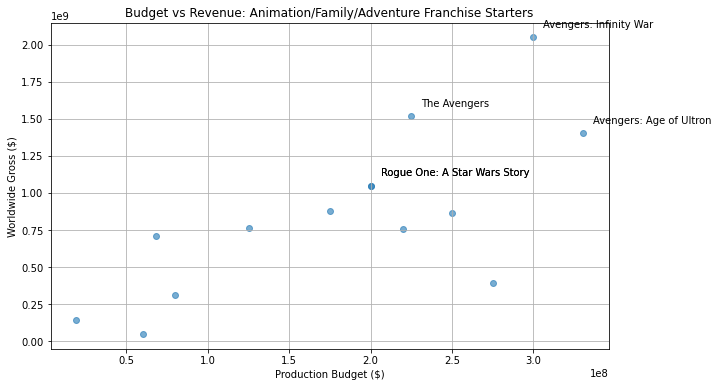

In [10]:
# Analyze top performing franchise starters in Animation/Family/Adventure
franchise_starters = merged_data[
   (merged_data['franchise_type'] == 'Franchise Starter') & 
   (merged_data['genre_list'].apply(lambda x: any(genre in x for genre in ['Animation', 'Family', 'Adventure'])))
]

print("Top Franchise Starters (Animation/Family/Adventure):")
print(franchise_starters.nlargest(10, 'worldwide_gross')[
   ['movie', 'genre_list', 'production_budget', 'worldwide_gross', 'ROI']
])

# Visualize budget vs revenue relationship for successful starters
plt.figure(figsize=(10, 6))
plt.scatter(franchise_starters['production_budget'], 
          franchise_starters['worldwide_gross'],
          alpha=0.6)
plt.title('Budget vs Revenue: Animation/Family/Adventure Franchise Starters')
plt.xlabel('Production Budget ($)')
plt.ylabel('Worldwide Gross ($)')

# Add annotations for top performers
for idx, row in franchise_starters.nlargest(5, 'worldwide_gross').iterrows():
   plt.annotate(row['movie'], 
               (row['production_budget'], row['worldwide_gross']),
               xytext=(10, 10), textcoords='offset points')
plt.grid(True)

<ipython-input-11-db5d0458bac9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  franchise_starters['budget_tier'] = pd.qcut(franchise_starters['production_budget'], 4, labels=['Low', 'Medium', 'High', 'Very High'])


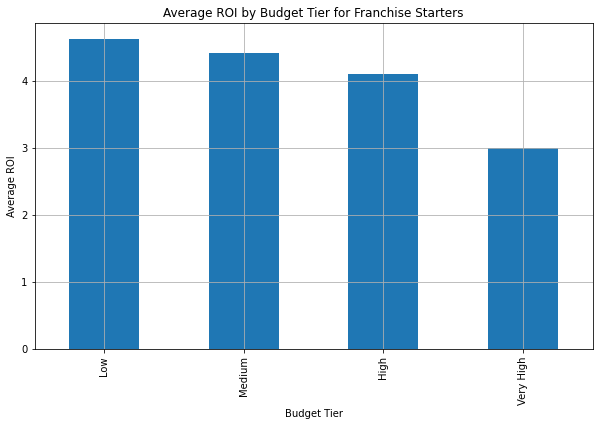

In [11]:
# Create budget tiers and analyze success rate
franchise_starters['budget_tier'] = pd.qcut(franchise_starters['production_budget'], 4, labels=['Low', 'Medium', 'High', 'Very High'])
plt.figure(figsize=(10, 6))
success_rate = franchise_starters.groupby('budget_tier')['ROI'].agg(['mean', 'count'])
success_rate['mean'].plot(kind='bar')
plt.title('Average ROI by Budget Tier for Franchise Starters')
plt.xlabel('Budget Tier')
plt.ylabel('Average ROI')
plt.grid(True)

Budget Tier Analysis:
            production_budget                       worldwide_gross   ROI
                         mean        min        max            mean  mean
budget_tier                                                              
Low                  56750000   19000000   80000000    3.016731e+08  4.63
Medium              175000000  125000000  200000000    9.362368e+08  4.41
High                222500000  220000000  225000000    1.137913e+09  4.10
Very High           288900000  250000000  330600000    1.177950e+09  2.99


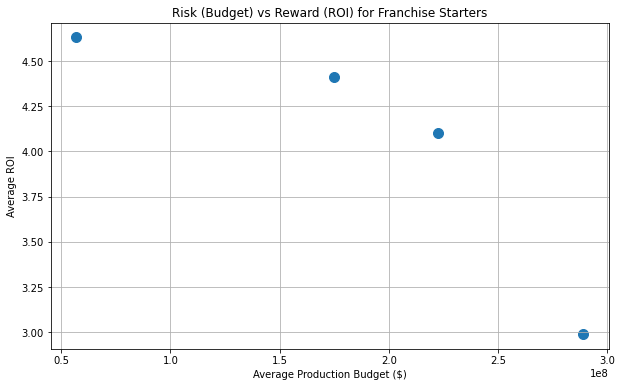

In [12]:
# Get the actual budget ranges and performance metrics for each tier
budget_analysis = franchise_starters.groupby('budget_tier').agg({
    'production_budget': ['mean', 'min', 'max'],
    'worldwide_gross': 'mean',
    'ROI': 'mean'
}).round(2)

print("Budget Tier Analysis:")
print(budget_analysis)

# Create a final visualization showing risk vs reward
plt.figure(figsize=(10, 6))
plt.scatter(budget_analysis[('production_budget', 'mean')], 
           budget_analysis[('ROI', 'mean')],
           s=100)
plt.title('Risk (Budget) vs Reward (ROI) for Franchise Starters')
plt.xlabel('Average Production Budget ($)')
plt.ylabel('Average ROI')
plt.grid(True)

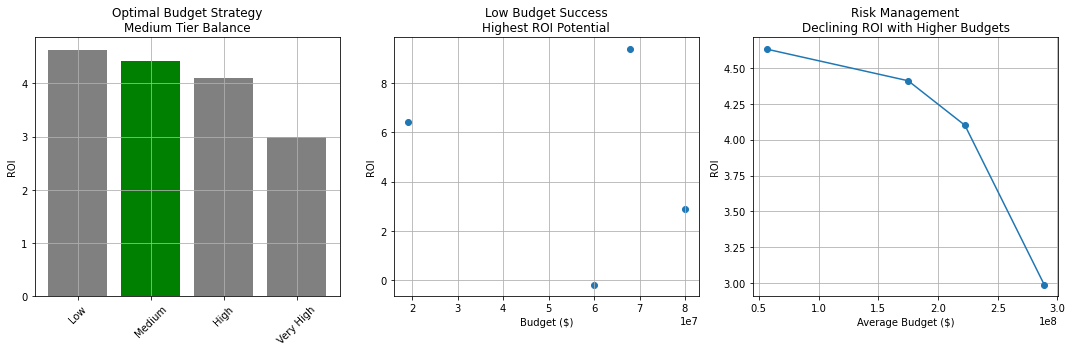

In [13]:
# Create three subplots, one for each recommendation
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# 1. Optimal Budget Strategy - Bar chart comparing ROI across budget tiers
medium_comparison = budget_analysis[('ROI', 'mean')]
ax1.bar(['Low', 'Medium', 'High', 'Very High'], medium_comparison, color=['gray', 'green', 'gray', 'gray'])
ax1.set_title('Optimal Budget Strategy\nMedium Tier Balance')
ax1.set_ylabel('ROI')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

# 2. Low Budget ROI Success - Scatter plot of budget vs ROI for low budget films
low_budget = franchise_starters[franchise_starters['budget_tier'] == 'Low']
ax2.scatter(low_budget['production_budget'], low_budget['ROI'])
ax2.set_title('Low Budget Success\nHighest ROI Potential')
ax2.set_xlabel('Budget ($)')
ax2.set_ylabel('ROI')
ax2.grid(True)

# 3. Risk Management - Line plot showing declining ROI with budget
ax3.plot(budget_analysis[('production_budget', 'mean')], budget_analysis[('ROI', 'mean')], marker='o')
ax3.set_title('Risk Management\nDeclining ROI with Higher Budgets')
ax3.set_xlabel('Average Budget ($)')
ax3.set_ylabel('ROI')
ax3.grid(True)

plt.tight_layout()

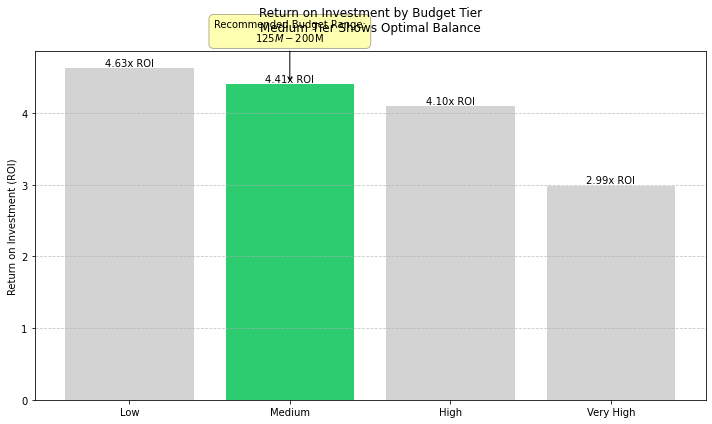

In [14]:
# Create a clear visualization for optimal budget strategy
plt.figure(figsize=(10, 6))

# Bar colors
colors = ['lightgray', '#2ecc71', 'lightgray', 'lightgray']  # Green highlight for medium tier

# Create bar chart
bars = plt.bar(['Low', 'Medium', 'High', 'Very High'], 
              budget_analysis[('ROI', 'mean')],
              color=colors)

# Add value labels on top of bars
for bar in bars:
   height = bar.get_height()
   plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}x ROI',
            ha='center', va='bottom')

# Customize the chart
plt.title('Return on Investment by Budget Tier\nMedium Tier Shows Optimal Balance', 
         pad=20, fontsize=12)
plt.ylabel('Return on Investment (ROI)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotation highlighting medium tier
plt.annotate('Recommended Budget Range:\n$125M-$200M',
           xy=(1, 4.41),
           xytext=(1, 5),
           ha='center',
           bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
           arrowprops=dict(arrowstyle='->'))

plt.tight_layout()

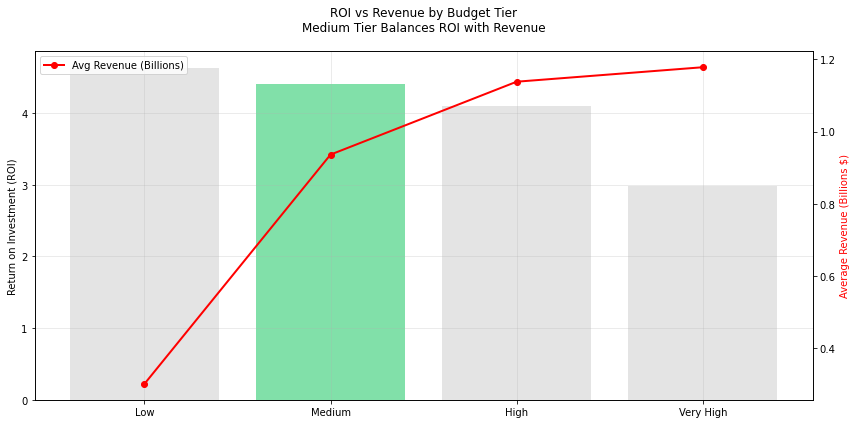

In [15]:
# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Bar colors
colors = ['lightgray', '#2ecc71', 'lightgray', 'lightgray']

# Plot ROI bars
bars = ax1.bar(['Low', 'Medium', 'High', 'Very High'], 
               budget_analysis[('ROI', 'mean')],
               color=colors,
               alpha=0.6)

# Plot average revenue line
ax2.plot(['Low', 'Medium', 'High', 'Very High'],
         budget_analysis[('worldwide_gross', 'mean')]/1e9,
         color='red',
         marker='o',
         linewidth=2,
         label='Avg Revenue (Billions)')

# Customize axes
ax1.set_ylabel('Return on Investment (ROI)', color='black')
ax2.set_ylabel('Average Revenue (Billions $)', color='red')

# Add title
plt.title('ROI vs Revenue by Budget Tier\nMedium Tier Balances ROI with Revenue', pad=20)

# Add legend
ax2.legend()

# Add grid
ax1.grid(True, alpha=0.3)

plt.tight_layout()

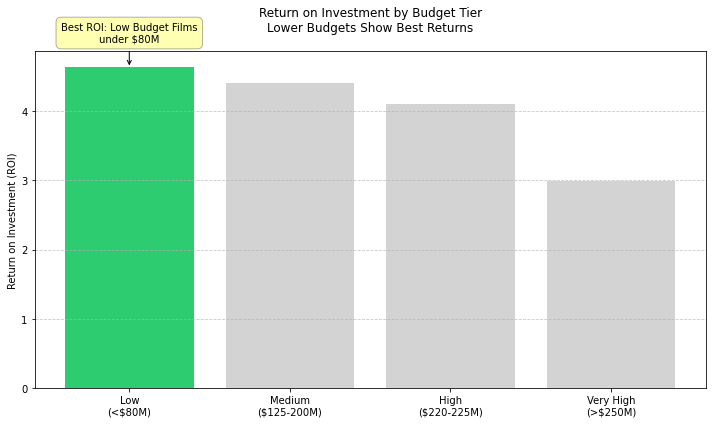

In [16]:
plt.figure(figsize=(10, 6))

# Create bar chart with ROI
plt.bar(['Low\n(<$80M)', 'Medium\n($125-200M)', 'High\n($220-225M)', 'Very High\n(>$250M)'], 
        budget_analysis[('ROI', 'mean')],
        color=['#2ecc71', 'lightgray', 'lightgray', 'lightgray'])  # Green highlight for low tier

plt.title('Return on Investment by Budget Tier\nLower Budgets Show Best Returns', 
          pad=20, fontsize=12)
plt.ylabel('Return on Investment (ROI)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add key insight annotation
plt.annotate('Best ROI: Low Budget Films\nunder $80M',
            xy=(0, 4.63),
            xytext=(0, 5),
            ha='center',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->'))

plt.tight_layout()

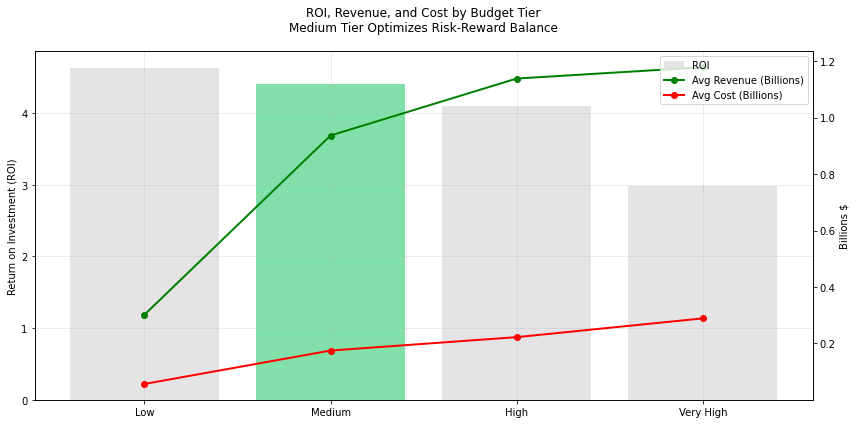

In [17]:
# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Bar colors
colors = ['lightgray', '#2ecc71', 'lightgray', 'lightgray']

# Plot ROI bars
bars = ax1.bar(['Low', 'Medium', 'High', 'Very High'], 
               budget_analysis[('ROI', 'mean')],
               color=colors,
               alpha=0.6,
               label='ROI')

# Plot average revenue line
revenue_line = ax2.plot(['Low', 'Medium', 'High', 'Very High'],
         budget_analysis[('worldwide_gross', 'mean')]/1e9,
         color='green',
         marker='o',
         linewidth=2,
         label='Avg Revenue (Billions)')

# Plot average cost line
cost_line = ax2.plot(['Low', 'Medium', 'High', 'Very High'],
         budget_analysis[('production_budget', 'mean')]/1e9,
         color='red',
         marker='o',
         linewidth=2,
         label='Avg Cost (Billions)')

# Customize axes
ax1.set_ylabel('Return on Investment (ROI)', color='black')
ax2.set_ylabel('Billions $', color='black')

# Add title
plt.title('ROI, Revenue, and Cost by Budget Tier\nMedium Tier Optimizes Risk-Reward Balance', pad=20)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Add grid
ax1.grid(True, alpha=0.3)

plt.tight_layout()

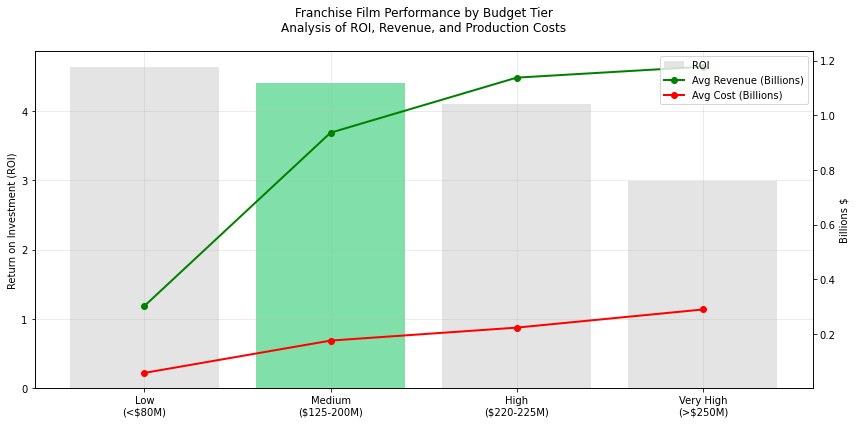

In [ ]:
# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Bar colors
colors = ['lightgray', '#2ecc71', 'lightgray', 'lightgray']

# Plot ROI bars
bars = ax1.bar(['Low\n(<$80M)', 'Medium\n($125-200M)', 'High\n($220-225M)', 'Very High\n(>$250M)'], 
               budget_analysis[('ROI', 'mean')],
               color=colors,
               alpha=0.6,
               label='ROI')

# Plot average revenue line
revenue_line = ax2.plot(['Low\n(<$80M)', 'Medium\n($125-200M)', 'High\n($220-225M)', 'Very High\n(>$250M)'],
         budget_analysis[('worldwide_gross', 'mean')]/1e9,
         color='green',
         marker='o',
         linewidth=2,
         label='Avg Revenue (Billions)')

# Plot average cost line
cost_line = ax2.plot(['Low\n(<$80M)', 'Medium\n($125-200M)', 'High\n($220-225M)', 'Very High\n(>$250M)'],
         budget_analysis[('production_budget', 'mean')]/1e9,
         color='red',
         marker='o',
         linewidth=2,
         label='Avg Cost (Billions)')

# Customize axes
ax1.set_ylabel('Return on Investment (ROI)', color='black')
ax2.set_ylabel('Billions $', color='black')

# Add title
plt.title('Franchise Film Performance by Budget Tier\nAnalysis of ROI, Revenue, and Production Costs', pad=20)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Add grid
ax1.grid(True, alpha=0.3)

plt.tight_layout()

Low Budget Franchise Films Sorted by ROI:
                           movie  production_budget  worldwide_gross       ROI
460   The Twilight Saga: Eclipse           68000000        706102828  9.383865
1301               Sausage Party           19000000        141344255  6.439171
382        The Lego Batman Movie           80000000        310660018  2.883250
21                  The Avengers           60000000         48585416 -0.190243


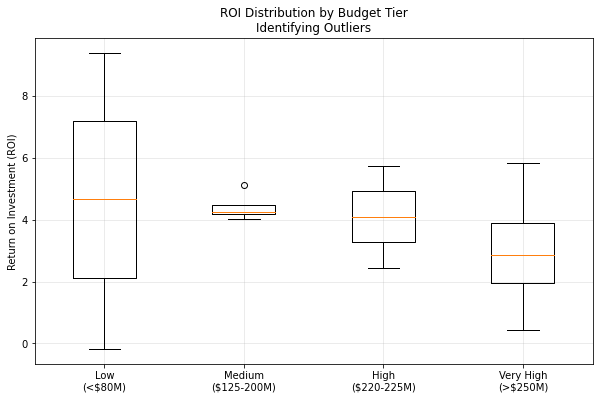

In [19]:
# Filter for low budget franchise films
low_budget_films = franchise_starters[franchise_starters['budget_tier'] == 'Low']

print("Low Budget Franchise Films Sorted by ROI:")
print(low_budget_films[['movie', 'production_budget', 'worldwide_gross', 'ROI']].sort_values('ROI', ascending=False))

# Create a box plot to show ROI distribution and identify outliers
plt.figure(figsize=(10, 6))
plt.boxplot([franchise_starters[franchise_starters['budget_tier'] == tier]['ROI'] 
            for tier in ['Low', 'Medium', 'High', 'Very High']], 
            labels=['Low\n(<$80M)', 'Medium\n($125-200M)', 'High\n($220-225M)', 'Very High\n(>$250M)'])
plt.title('ROI Distribution by Budget Tier\nIdentifying Outliers')
plt.ylabel('Return on Investment (ROI)')
plt.grid(True, alpha=0.3)

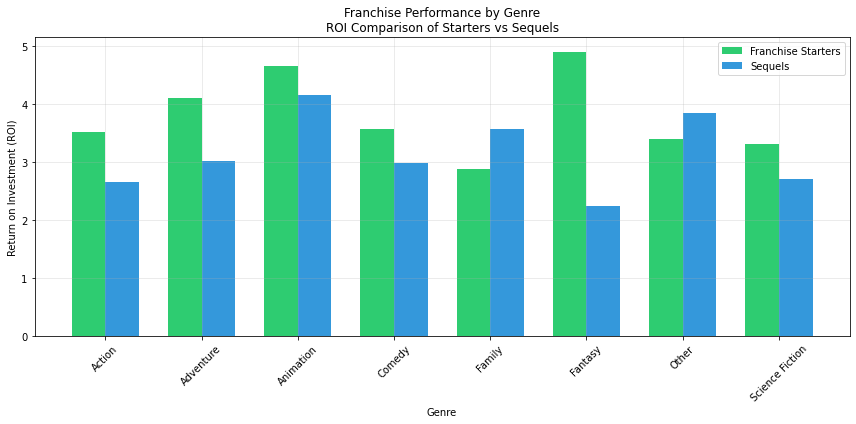

In [20]:
# Get franchise performance by genre
genre_franchise = merged_data.explode('genre_list').groupby(['genre_list', 'franchise_type']).agg({
   'production_budget': 'mean',
   'worldwide_gross': 'mean',
   'ROI': ['mean', 'count']
}).round(2)

# Create visualization
plt.figure(figsize=(12, 6))

# Get data for franchise starters and sequels
starters = genre_franchise.xs('Franchise Starter', level=1)[('ROI', 'mean')]
sequels = genre_franchise.xs('Sequel', level=1)[('ROI', 'mean')]

# Plot grouped bar chart
x = np.arange(len(starters))
width = 0.35

plt.bar(x - width/2, starters, width, label='Franchise Starters', color='#2ecc71')
plt.bar(x + width/2, sequels, width, label='Sequels', color='#3498db')

plt.title('Franchise Performance by Genre\nROI Comparison of Starters vs Sequels')
plt.xlabel('Genre')
plt.ylabel('Return on Investment (ROI)')
plt.xticks(x, starters.index, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

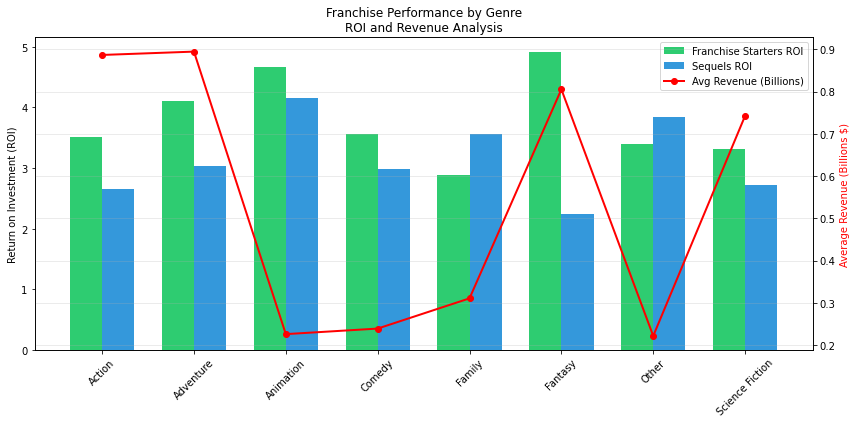

In [21]:
# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Width for bars
width = 0.35

# Get ROI data
starters_roi = genre_franchise.xs('Franchise Starter', level=1)[('ROI', 'mean')]
sequels_roi = genre_franchise.xs('Sequel', level=1)[('ROI', 'mean')]

# Get revenue data
starters_rev = genre_franchise.xs('Franchise Starter', level=1)[('worldwide_gross', 'mean')]/1e9
x = np.arange(len(starters_roi))

# Plot bars for ROI
ax1.bar(x - width/2, starters_roi, width, color='#2ecc71', label='Franchise Starters ROI')
ax1.bar(x + width/2, sequels_roi, width, color='#3498db', label='Sequels ROI')

# Plot line for revenue
ax2.plot(x, starters_rev, color='red', marker='o', linewidth=2, label='Avg Revenue (Billions)')

# Customize axes
ax1.set_ylabel('Return on Investment (ROI)', color='black')
ax2.set_ylabel('Average Revenue (Billions $)', color='red')

plt.title('Franchise Performance by Genre\nROI and Revenue Analysis')
ax1.set_xticks(x)
ax1.set_xticklabels(starters_roi.index, rotation=45)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True, alpha=0.3)
plt.tight_layout()

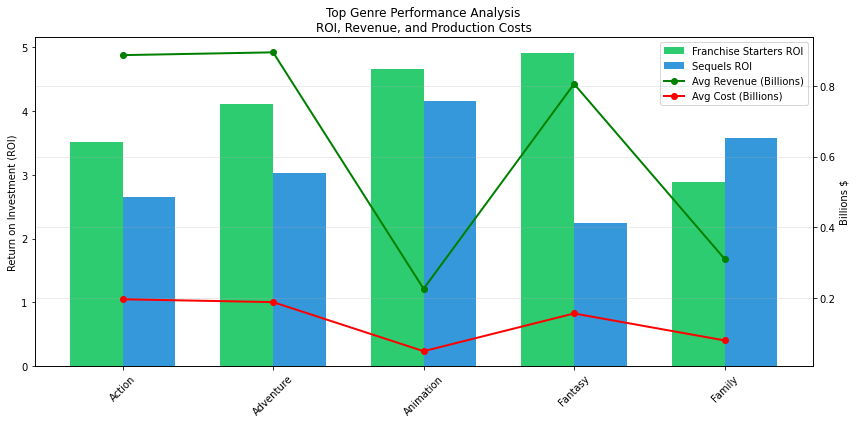

In [22]:
# Create figure with two y-axes - focusing on top genres
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Select top genres
top_genres = ['Action', 'Adventure', 'Animation', 'Fantasy', 'Family']

# Get data for top genres
starters_roi = genre_franchise.xs('Franchise Starter', level=1)[('ROI', 'mean')][top_genres]
sequels_roi = genre_franchise.xs('Sequel', level=1)[('ROI', 'mean')][top_genres]
revenue = genre_franchise.xs('Franchise Starter', level=1)[('worldwide_gross', 'mean')][top_genres]/1e9
costs = genre_franchise.xs('Franchise Starter', level=1)[('production_budget', 'mean')][top_genres]/1e9

# Width for bars
width = 0.35
x = np.arange(len(top_genres))

# Plot bars for ROI
ax1.bar(x - width/2, starters_roi, width, color='#2ecc71', label='Franchise Starters ROI')
ax1.bar(x + width/2, sequels_roi, width, color='#3498db', label='Sequels ROI')

# Plot lines for revenue and cost
ax2.plot(x, revenue, color='green', marker='o', linewidth=2, label='Avg Revenue (Billions)')
ax2.plot(x, costs, color='red', marker='o', linewidth=2, label='Avg Cost (Billions)')

# Customize axes
ax1.set_ylabel('Return on Investment (ROI)', color='black')
ax2.set_ylabel('Billions $', color='black')

plt.title('Top Genre Performance Analysis\nROI, Revenue, and Production Costs')
ax1.set_xticks(x)
ax1.set_xticklabels(top_genres, rotation=45)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True, alpha=0.3)
plt.tight_layout()

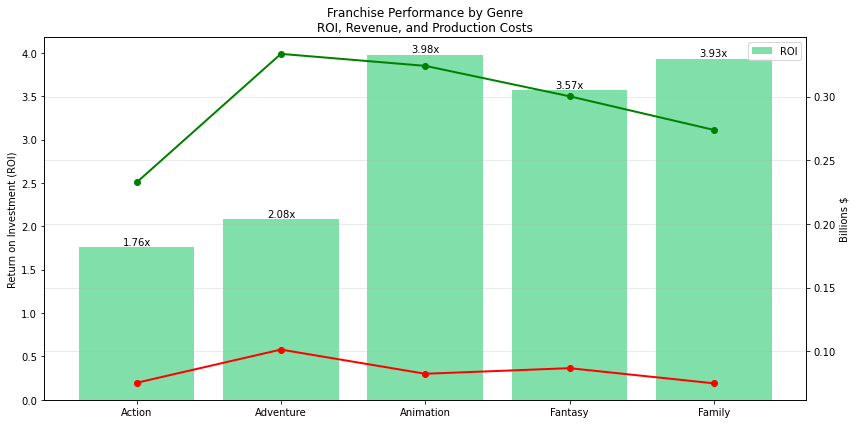

In [23]:
# Create figure with two y-axes - focusing on top genres, combined franchise performance
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Select top genres
top_genres = ['Action', 'Adventure', 'Animation', 'Fantasy', 'Family']

# Get combined data for franchises
franchise_data = merged_data.explode('genre_list').groupby('genre_list').agg({
   'ROI': 'mean',
   'worldwide_gross': 'mean',
   'production_budget': 'mean'
})

# Get data for selected genres
roi = franchise_data.loc[top_genres, 'ROI']
revenue = franchise_data.loc[top_genres, 'worldwide_gross']/1e9
costs = franchise_data.loc[top_genres, 'production_budget']/1e9

# Plot ROI bars
bars = ax1.bar(top_genres, roi, color='#2ecc71', alpha=0.6)

# Plot lines for revenue and cost
ax2.plot(top_genres, revenue, color='green', marker='o', linewidth=2, label='Avg Revenue (Billions)')
ax2.plot(top_genres, costs, color='red', marker='o', linewidth=2, label='Avg Cost (Billions)')

# Customize axes
ax1.set_ylabel('Return on Investment (ROI)', color='black')
ax2.set_ylabel('Billions $', color='black')

plt.title('Franchise Performance by Genre\nROI, Revenue, and Production Costs')
plt.xticks(rotation=45)

# Add ROI values on top of bars
for bar in bars:
   height = bar.get_height()
   ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}x',
            ha='center', va='bottom')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(['ROI'] + labels2, loc='upper right')

plt.grid(True, alpha=0.3)
plt.tight_layout()

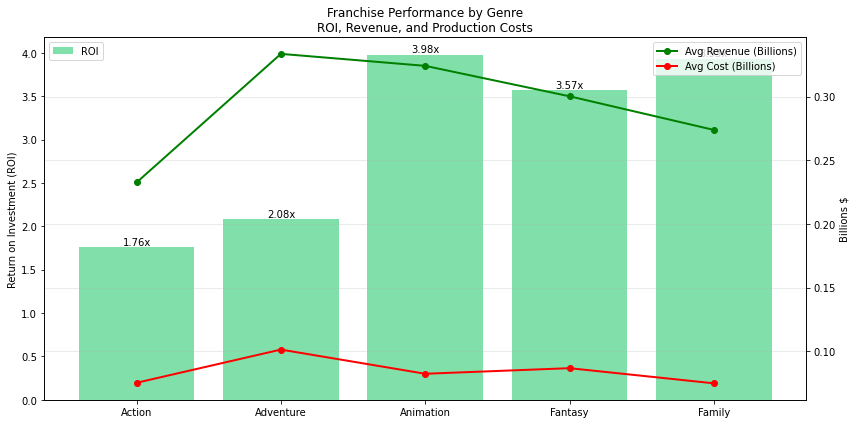

In [24]:
# Create figure with two y-axes - focusing on top genres, combined franchise performance
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Select top genres
top_genres = ['Action', 'Adventure', 'Animation', 'Fantasy', 'Family']

# Get combined data for franchises
franchise_data = merged_data.explode('genre_list').groupby('genre_list').agg({
   'ROI': 'mean',
   'worldwide_gross': 'mean',
   'production_budget': 'mean'
})

# Get data for selected genres
roi = franchise_data.loc[top_genres, 'ROI']
revenue = franchise_data.loc[top_genres, 'worldwide_gross']/1e9
costs = franchise_data.loc[top_genres, 'production_budget']/1e9

# Plot ROI bars
bars = ax1.bar(top_genres, roi, color='#2ecc71', alpha=0.6, label='ROI')

# Plot lines for revenue and cost
line1 = ax2.plot(top_genres, revenue, color='green', marker='o', linewidth=2, label='Avg Revenue (Billions)')
line2 = ax2.plot(top_genres, costs, color='red', marker='o', linewidth=2, label='Avg Cost (Billions)')

# Customize axes
ax1.set_ylabel('Return on Investment (ROI)', color='black')
ax2.set_ylabel('Billions $', color='black')

plt.title('Franchise Performance by Genre\nROI, Revenue, and Production Costs')
plt.xticks(rotation=45)

# Add ROI values on top of bars
for bar in bars:
   height = bar.get_height()
   ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}x',
            ha='center', va='bottom')

# Add legends for all elements
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True, alpha=0.3)
plt.tight_layout()